In [17]:
import numpy as np
import pandas as pd
from os import listdir
from os.path import join, isfile

# info tables
src_info = f'/data01/homes/dipiano/E4/z60_NLST/crab/theoretical/merged_data.dat'

# dataset 
filename = '/data01/homes/dipiano/E4/z60_NLST/ds_50s_5sgm_1000sz.npy'
ds = np.load(filename, allow_pickle=True, encoding='latin1', fix_imports=True).flat[0]
print(f"Classes: {ds.keys()}\n")
print(f"\nSRC dataset size: {len(ds['SRC'])}")
print(f"BKG dataset size: {len(ds['BKG'])}")

Classes: dict_keys(['SRC', 'BKG'])


SRC dataset size: 1000
BKG dataset size: 1000


In [18]:
from astroai.tools.utils import split_noisy_dataset

train_clean, train_noisy, test_clean, test_noisy = split_noisy_dataset(ds, split=80, reshape=True, binning=250)

print(f"Train clean: {train_clean.shape}")
print(f"Train noisy: {train_noisy.shape}")
print(f"\nTest clean: {test_clean.shape}")
print(f"Test labenoicyls: {test_noisy.shape}")

Train clean: (800, 250, 250, 1)
Train noisy: (800, 250, 250, 1)

Test clean: (200, 250, 250, 1)
Test labenoicyls: (200, 250, 250, 1)


# !!! I NEED TO SIMULATE SAME POINTING !!!

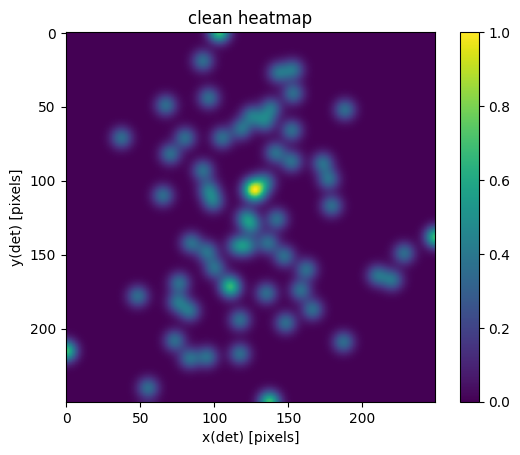

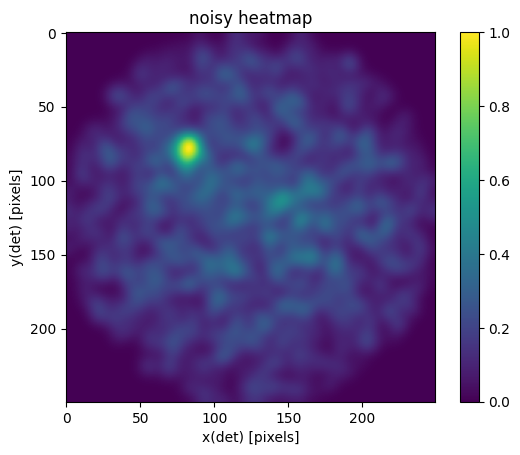

In [19]:
from astroai.tools.utils import plot_heatmap

plot_heatmap(train_clean[0], title=f'clean heatmap', show=True, save=False, save_name=None)
plot_heatmap(train_noisy[0], title=f'noisy heatmap', show=True, save=False, save_name=None)

In [14]:
import tensorflow as tf
from datetime import datetime

input_img = tf.keras.Input(shape=(250, 250, 1))
x = tf.keras.layers.Conv2D(50, (5, 5), activation='relu', padding='same')(input_img)
x = tf.keras.layers.MaxPooling2D((5, 5), padding='same')(x)
x = tf.keras.layers.Conv2D(50, (5, 5), activation='relu', padding='same')(x)
encoded = tf.keras.layers.MaxPooling2D((5, 5), padding='same')(x)

# At this point the representation is (7, 7, 32)
x = tf.keras.layers.Conv2D(50, (5, 5), activation='relu', padding='same')(encoded)
x = tf.keras.layers.UpSampling2D((5, 5))(x)
x = tf.keras.layers.Conv2D(50, (5, 5), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((5, 5))(x)
decoded = tf.keras.layers.Conv2D(1, (5, 5), activation='sigmoid', padding='same')(x)

autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 250, 250, 1)]     0         
                                                                 
 conv2d_40 (Conv2D)          (None, 250, 250, 50)      1300      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 50, 50, 50)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 50, 50, 50)        62550     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 10, 10, 50)       0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 10, 10, 50)        6255

In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

logdir = join("logs", "cnn-v01-clean" + datetime.now().strftime("%Y%m%dT%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

autoencoder.fit(train_noisy, train_clean, epochs=5, batch_size=32, shuffle=True,
                validation_data=(test_noisy, test_clean),
                callbacks=[tensorboard_callback])

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2)
ax[0].plot(history.history['accuracy'], label='accuracy')
ax[0].plot(history.history['val_accuracy'], label = 'val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim([0,1])
ax[0].legend(loc='lower right')

ax[1].plot(history.history['loss'], label='loss')
ax[1].plot(history.history['val_loss'], label = 'val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_ylim([0,1])
ax[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=2)

In [ ]:
encoded_imgs = encoder.predict(x_test_noisy)
decoded_imgs = decoder.predict(encoded_imgs)

n = 10  # how many plots we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()